# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [149]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [150]:
#Load your data into a pandas dataframe here
# Load the data from CSV file

df = pd.read_csv('household_power_clean.csv')

# Check the column labels in the DataFrame
df.dtypes




Unnamed: 0                 int64
Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Datetime                  object
gap_monthly              float64
grp_monthly              float64
v_monthly                float64
gi_monthly               float64
dtype: object

In [151]:
#converting datetime to epoch/unix time

df['Datetime'] = pd.to_datetime(df['Datetime']).astype(str)
df['unix'] = (pd.to_datetime(df['Datetime']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df.head(5)

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1166289840
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1166289900
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1166289960
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1166290020
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: Ph and mu are the two model parameters. ph is the predictive horizon, using which predictions are made. Here GAP (Global Active Power values are supposed to be predicted), where ph is set to 5 minutes, means we have to predict the GAP value five minutes into the future.
Also, mu is the forgetting factor, which "exponentially decays the data from history". In the given code, mu is set to 0.9, which means that algorithm gives more weight to the latest data, but also considers historical data to some extent, giving it less power while still giving the model enough information to make an efficient prediction. But when it is set to 1, the entire history is counted in making the prediction.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [152]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)
df.head(5)


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1166289840
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1166289900
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1166289960
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1166290020
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1166290080


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:  With mu = 0.9, the weight for first data point in the limited data set will be approximately, 1.35e-244.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [153]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

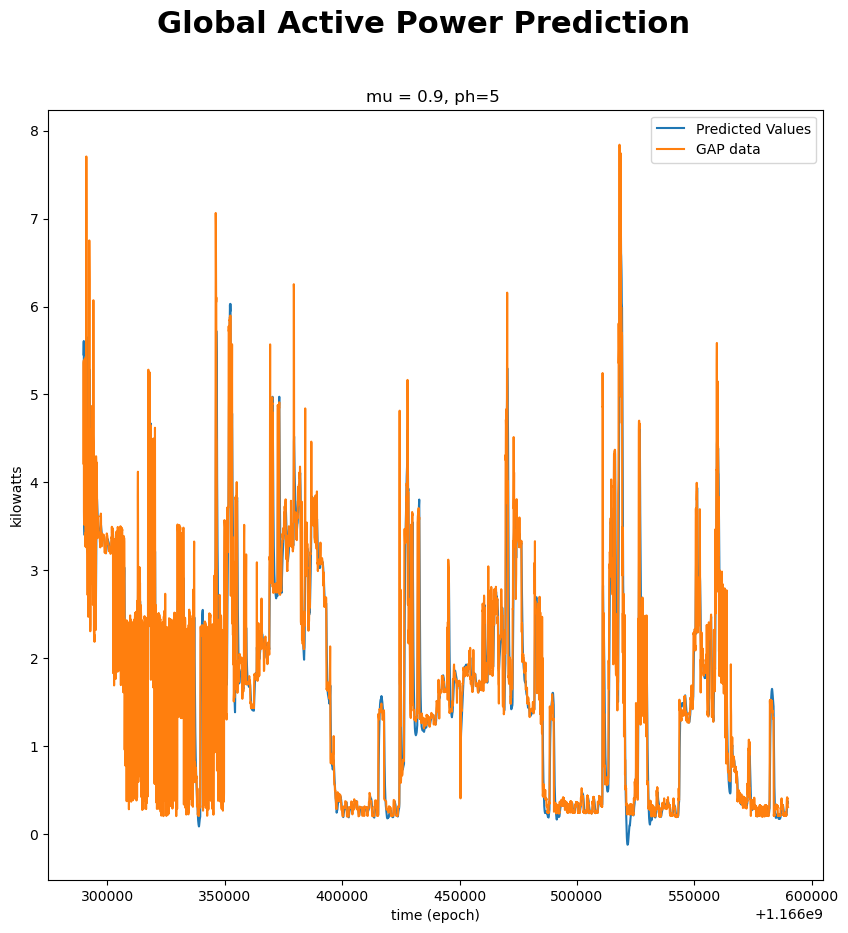

In [154]:
# creating a new figure with a size of 10x10 inches
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')

# adding a title to the plot with the values of mu and ph
ax.set_title('mu = %g, ph=%g ' %(mu, ph))

#plotting the predicted values with the corresponding time points

ax.plot(tp_pred, yp_pred, label='Predicted Values') 

# plotting the actual values with the corresponding time points
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 

ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

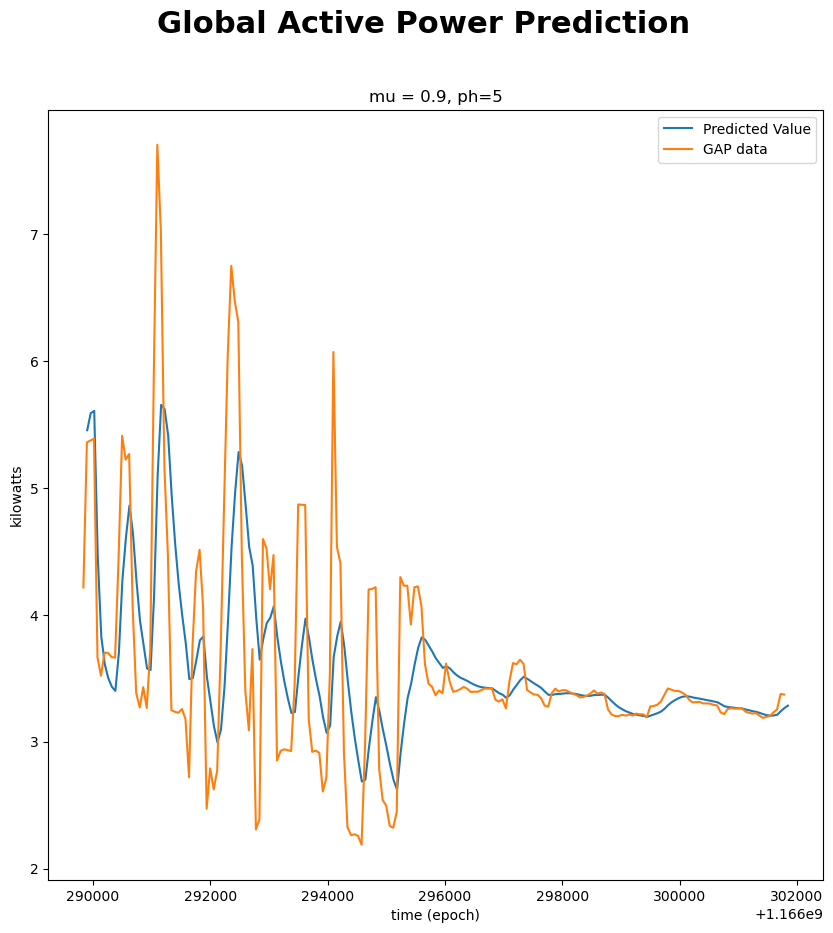

In [155]:
#Plot first 200 data points/predictions


t_tot = [l for l in range(int (min(tp_pred)), int(min(tp_pred+3000)))]

fig, ax = plt.subplots (figsize= (10,10))
fig. suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')

ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()

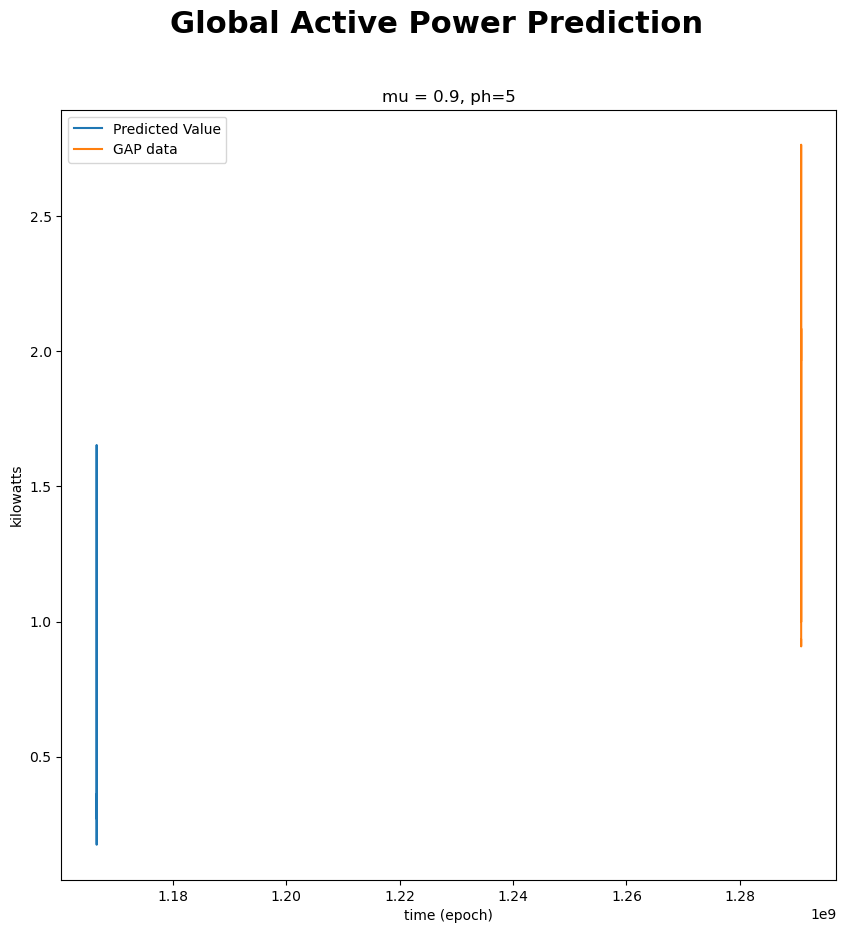

In [156]:
#Plot last 200 data points/predictions


fig, ax = plt.subplots (figsize= (10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()



In [160]:

from sklearn.metrics import mean_squared_error as mse
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3765548530707918


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: According to the MSE value obtained, which is 0.1756, and from the above chart, it can be observed that our model's performance is not actually accurate, which means the predictions are also not very accurate, because a lower MSE means better performance. 
The above plot shows that this model follows the trend of the real data; additionally, it also has complexity in identifying the variability. And the last predictions have little huge errors when compared to initial predictions. However, there is a slight difference between the initial predictions and the last 200 predictions.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

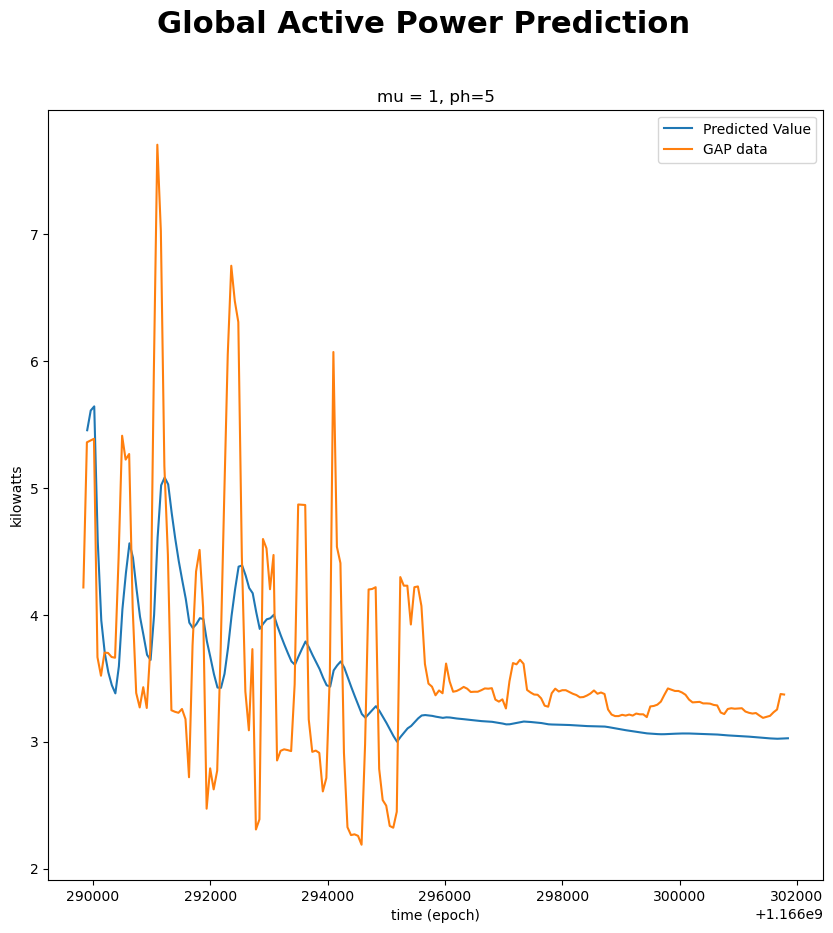

In [161]:
#Plot first 200 data points/predictions for mu = 1
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)
df.head(5)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    
t_tot = [l for l in range(int (min(tp_pred)), int(min(tp_pred+3000)))]

fig, ax = plt.subplots (figsize= (10,10))
fig. suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')

ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()

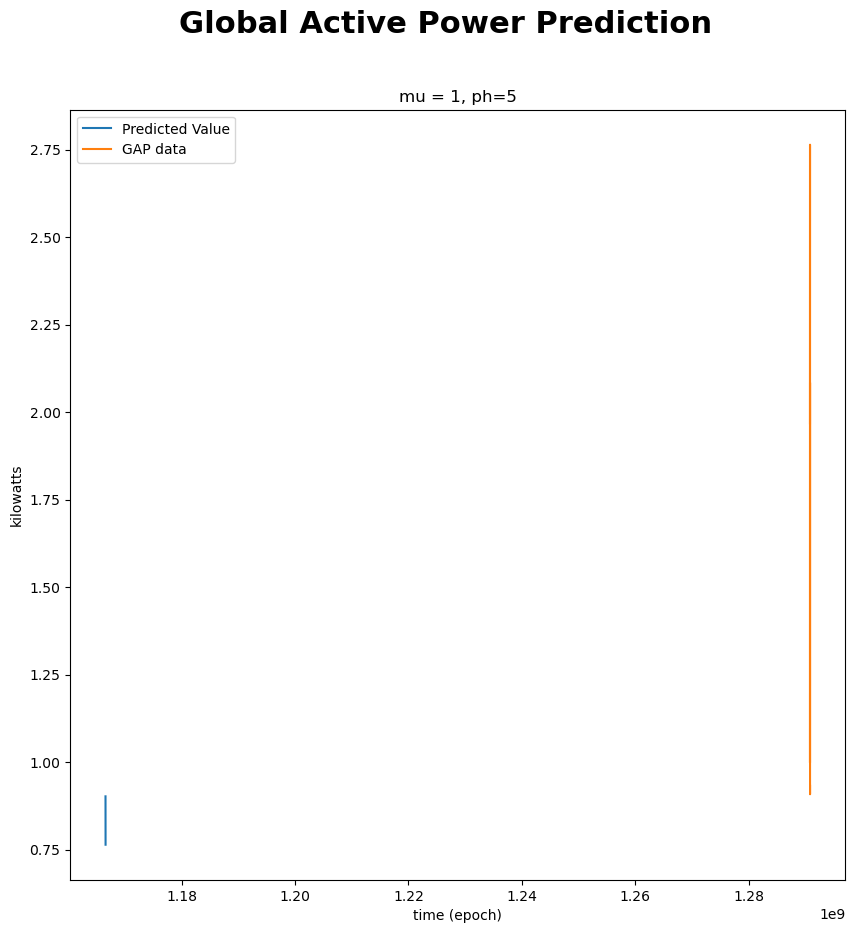

In [162]:
#Plot last 200 data points/predictions for mu = 1

ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)
df.head(5)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    
fig, ax = plt.subplots (figsize= (10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()

In [163]:
#Calculate MSE of predictions for mu = 1

print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3765548530707918


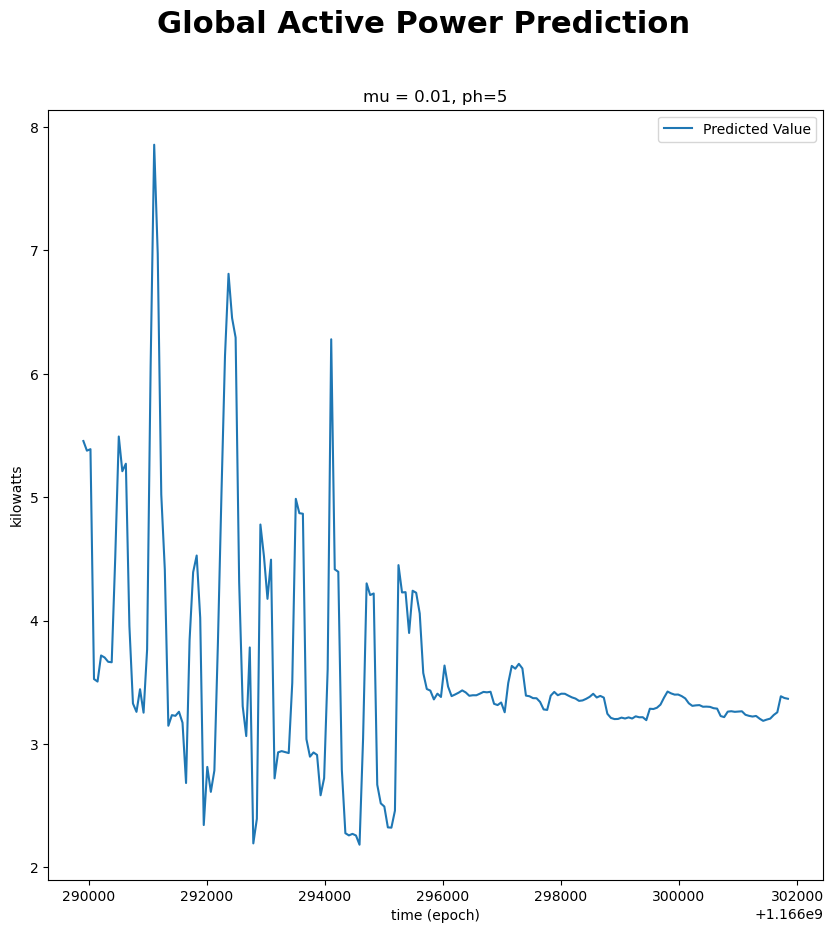

In [164]:
#Plot first 200 data points/predictions for mu = 0.01


ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)
df.head(5)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    
t_tot = [l for l in range(int (min(tp_pred)), int(min(tp_pred+3000)))]

fig, ax = plt.subplots (figsize= (10,10))
fig. suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')

ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()

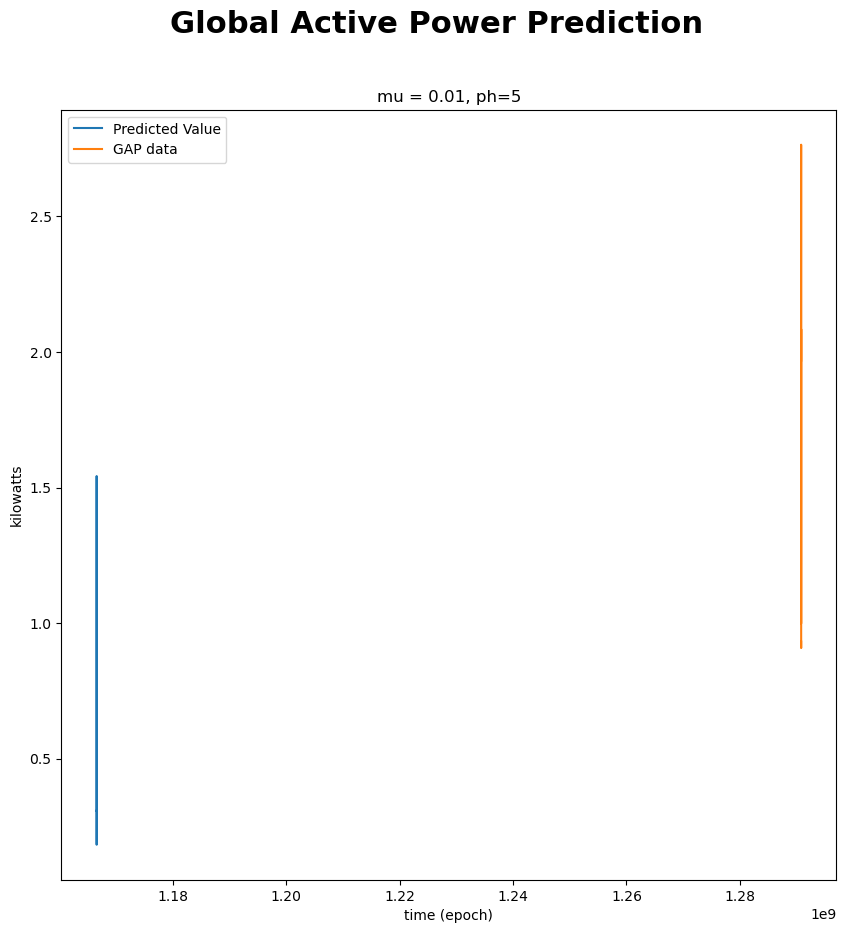

In [165]:
#Plot last 200 data points/predictions for mu = 0.01


ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = int(ph / (ts.iloc[1,0] - ts.iloc[0,0])) #ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)
df.head(5)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
        
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k 
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    
fig, ax = plt.subplots (figsize= (10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
ax.set_xlabel('time (epoch)') 
ax.set_ylabel('kilowatts')
ax.legend()

In [167]:
#Calculate MSE of predictions for mu = 0.01


print("MSE value is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE value is 0.29226945865173143


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: In the beginning, the model with mu = 1 performed properly, but later there was a decrease in the prediction accuracy. From the charts comparing the early and the late predictions, the early predictions appear to be accurate, while in the later predictions, there appears to be a significant difference between the expected and actual values. Hence, it can be seen that the model is not appropriate to make long-term predictions. For mu = 1, MSE is 1.376554, which says that the predicted values and the actual values hardly have any similarity.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: From the charts, at mu = 0.01 it can be said that the predictions are less accurate and do not nearly meet the actual values. Additionally, the performance of the model with mu = 0.01 does not even meet the accuracy provided by the model with mu = 1. Comparing the early and later predictions, there is a noticeable difference as the later predictions are more accurate. Hence, it can be said that the GAP in this data set cannot be efficiently predicted using a model with mu = 0.01.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The choice of the mu parameter affects the performance of the model because it controls the size of the regularization penalty applied to the model coefficients. A larger value of mu leads to stronger regularization and may lead to a simpler model with fewer coefficients, but at the cost of a potentially higher bias. A smaller value of mu leads to weaker regularization and may allow the model to fit the data more closely, but at the cost of potentially higher variance. In this case, it appears that a moderate value of mu around 0.9 is leading to the best balance between bias and variance, resulting in the lowest MSE.

This can be said from the models because the model with mu = 1 has the highest MSE of 1.3765548530707918, which shows that it has the poorest performance in terms of predicting the response variable compared to the other two models. Similarly, the model with mu = 0.01 has an intermediate MSE of 0.29226945865173143, indicating that it is performing better than the model with mu = 1 but not as well as the model with mu = 0.9.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: There are several things that can be followed in order to improve the model and make it more accurate, such as collecting better quality data and incorporating extra features into the model to improve accuracy. Also, different modeling techniques can be used to better understand the complications of the problem. Performing validation to make sure the system is making accurate predictions.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [168]:
#add voltage to the x-variables in our dataset
ts = pd.concat([df.Global_active_power], axis=1)
ys = pd.DataFrame(df.Voltage)

ph = 300 # 5 minutes
ph_index = int(ph/2)
mu = 0.9

# limit the number of samples in our model to 5000 just for speed
n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)


In [169]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

# define update and predict functions
from sklearn.linear_model import LinearRegression

# define update and predict functions
def update(state, measurement, mu):
    return mu * state + (1 - mu) * measurement

def predict(state, mu, ph, coef):
    return state[ph]

# create a LinearRegression model
model = LinearRegression()

# fit the model to the data
model.fit(ts, ys)

# use the model to make predictions
yp_pred = model.predict(ts)

# update the prediction arrays
for i in range(n_s - 1):
    # get the current input and output values
    x = ts.iloc[i, :]
    y = ys.iloc[i, 0]
    # predict the next value
    y_pred = predict(x, mu, ph_index % 2, model.coef_)
    # update the prediction arrays
    tp_pred[i] = i + 1
    #updated_y_pred = y_pred
    # update the weights
    ts.iloc[i+1, :] = update(x, y_pred, mu)

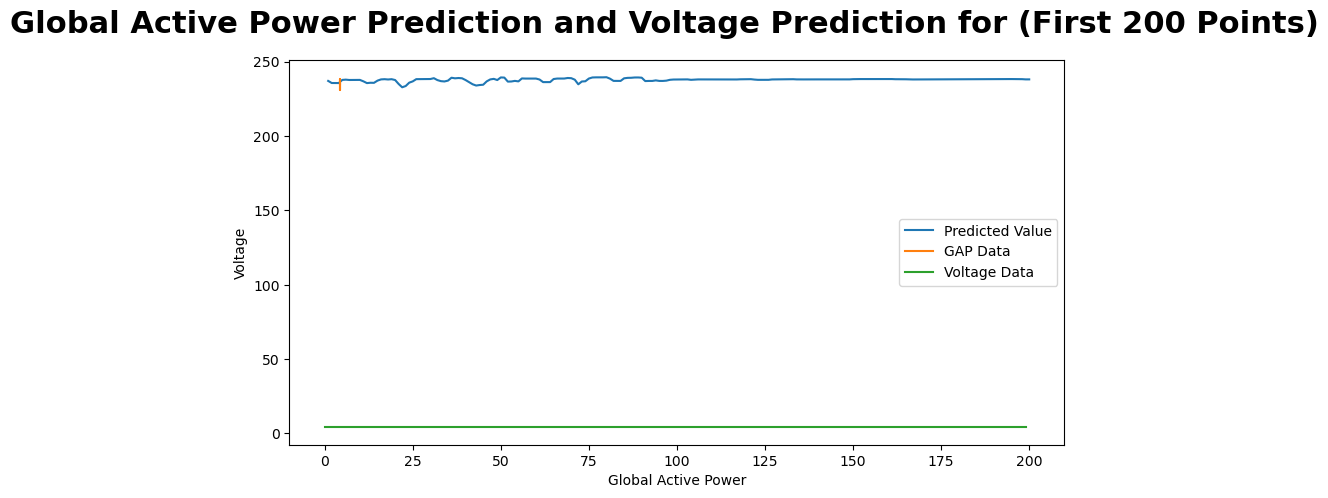

In [170]:
#Plot first 200 data points/predictions for the expanded dataset

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle('Global Active Power Prediction and Voltage Prediction for (First 200 Points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP Data')
ax.plot(ts.iloc[:200], label='Voltage Data')
ax.set_xlabel('Global Active Power')
ax.set_ylabel('Voltage')
ax.legend()

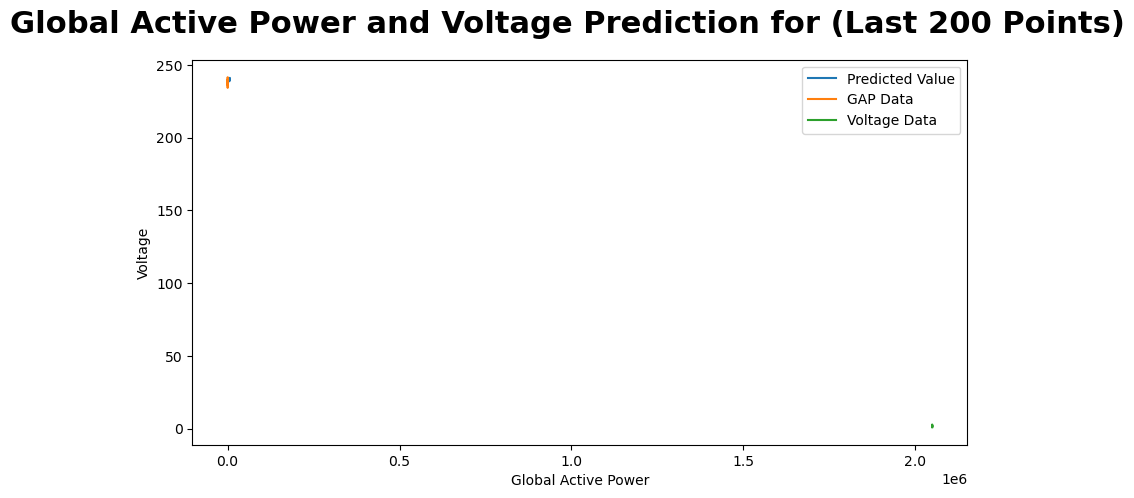

In [171]:
#Plot last 200 data points/predictions for the expanded data

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Global Active Power and Voltage Prediction for (Last 200 Points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP Data')
ax.plot(ts.iloc[-200:], label='Voltage Data')
ax.set_xlabel('Global Active Power')
ax.set_ylabel('Voltage')
ax.legend()

In [172]:
#Calculate MSE of predictions for the expanded data
#Calculate MSE of predictions for mu = 1

#print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

mse = mean_squared_error(ys, yp_pred)
print("MSE of predictions for expanded data: ", mse)

MSE of predictions for expanded data:  8.819908595797385


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Adding the voltage data, it can be observed that it has a higher MSE score, and comparing the models with and without voltage data, the one with added voltage performs poorly. However, the model’s ability to predict the changes occurring in GAP can be improved by adding voltage data.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: The alternate model might improve our model because using a moving average can reduce the variations that are in the time series data and reduce the noise. In this way, it can supply comparatively accurate predictions. It can also help in minimizing the effects of outliers in the data and identifying the trends in the data with which there can be accurate performance from the model.

In [173]:
#create your alternative training data here


df['Datetime'] = pd.to_datetime(df['Datetime'])
# create a new column for hour of day
df['hour'] = df['Datetime'].dt.hour
# create your alternative training data here
ts = df['hour'].values
ys = pd.DataFrame(df['Global_active_power'])
ph = 300
ph_index = int(ph/60) #number of minutes in ph
mu = 0.9
#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000
#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)


In [174]:
#re-run the prediction code here
def update(state, measurement, mu):
 return mu * state + (1 - mu) * measurement
def predict(state, mu, ph):
 return state
for i in range(n_s - 1):
 # get the current input and output values
 x = ts[i]
 y = ys.iloc[i, 0]
 # predict the next value
 y_pred = predict(x, mu, ph_index % 2)
 # update the prediction arrays
 tp_pred[i] = i + 1
 yp_pred[i] = y_pred
 # update the weights
 ts[i+1] = update(x, y_pred, mu)

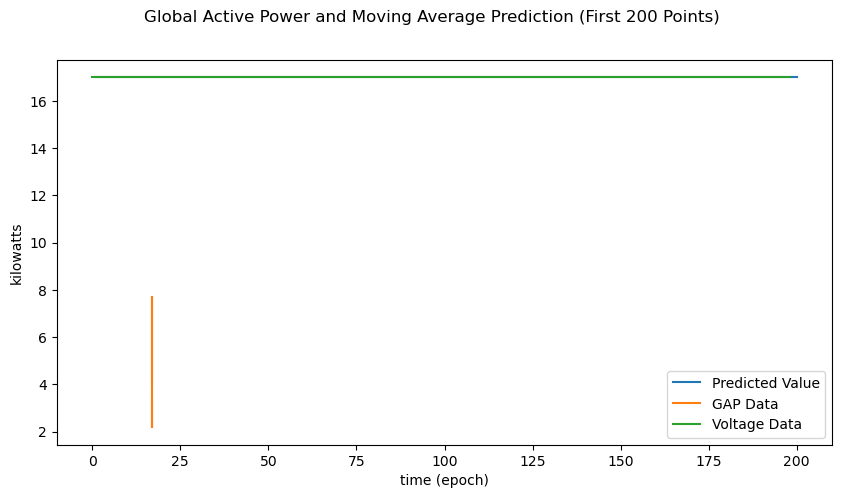

In [175]:
#Plot first 200 data points/predictions for alternative model

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Global Active Power and Moving Average Prediction (First 200 Points)')
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts[:200], ys.iloc[:200, 0], label='GAP Data')
ax.plot(ts[:199], label='Voltage Data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


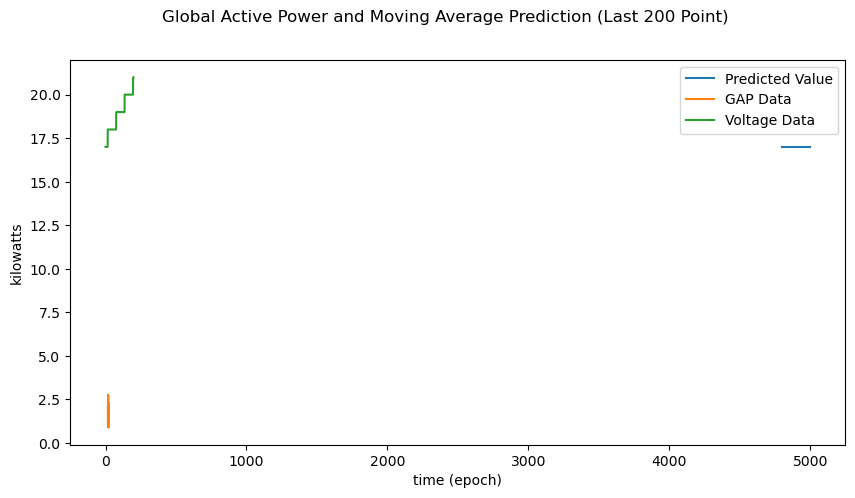

In [176]:
#Plot last 200 data points/predictions for alternative model

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Global Active Power and Moving Average Prediction (Last 200 Point)')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts[-200:], ys.iloc[-200:, 0], label='GAP Data')
ax.plot(ts[-199:], label='Voltage Data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [177]:
#Calculate MSE of predictions for alternative model
mse = np.mean((ys.iloc[1:n_s].values.squeeze() - yp_pred)**2)
print('MSE: ', mse)

MSE:  235.24372311662333


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:Yes, our alternate model has shown major improvement compared to the previous results, as the MSE is 235.2437. However, minor improvements that can be made even when using linear regression include,

Trying different variations of linear regression models such as ridge regression and lasso regression and choosing the one that performs most efficiently on the data.

Using regularization techniques like L1 or L2 to reduce overfitting and improve the model’s generation ability.

Also, since outliers can also have a major effect on performance, it is important to consider removing outliers and using robust regression techniques, which can be less sensitive to outliers.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.